# Project 5 - Vehicle Detection

In this project, my goal is to write a software pipeline to detect vehicles in a video, and to document the process and results in loacted in ReadME.

### Project Steps:

The goals / steps of this project are the following:

- Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
- Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
- Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
- Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
- Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
- Estimate a bounding box for vehicles detected.


 ### Import Libraries Required:

In [1]:
import cv2
import glob
import numpy as np

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.neural_network import MLPClassifier

from sklearn.preprocessing import StandardScaler
from skimage.feature import hog

import time

### Load Classifier training Data

In [2]:
# Read in our vehicles and non-vehicles. 

non_images = glob.glob('training_images/non-vehicles/*.png')
car_images = glob.glob('training_images/vehicles/*/*.png')
cars = []
notcars = []

for nimage in non_images:
    notcars.append(nimage)
for cimage in car_images:
    cars.append(cimage)

n_ncartrain =len(notcars)
n_cartrain =len(cars)

print("Number of Non-car Images:", n_ncartrain)
print("Number of Car Images:",n_cartrain)   

Number of Non-car Images: 8968
Number of Car Images: 8792


## Explore Data

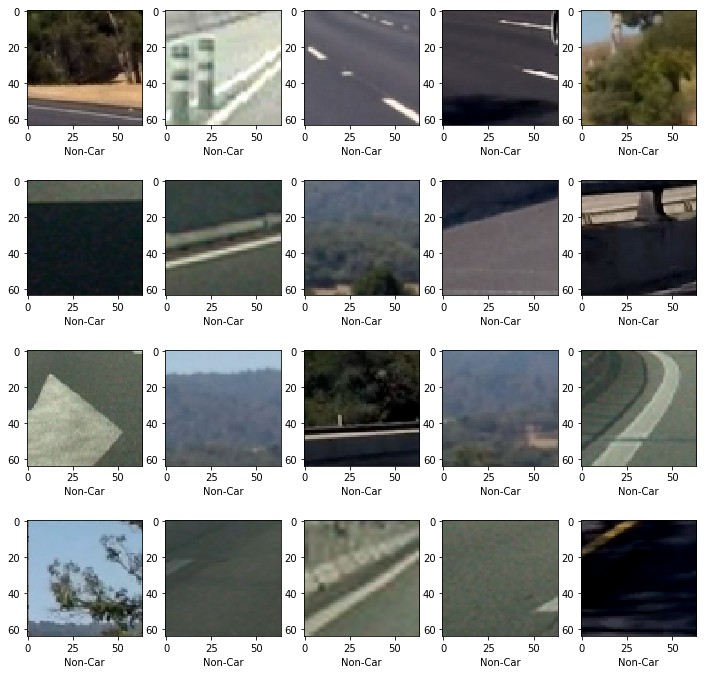

In [3]:
import random

Num_Show = 20
plt.figure(figsize=(12,12))

for x in range(Num_Show):
    rnd_int =random.randint(0,n_ncartrain)
    rndImg = mpimg.imread(notcars[rnd_int])
    plt.subplot(4,5,x+1)
    plt.imshow(rndImg)
    plt.xlabel('Non-Car')
  
plt.show()

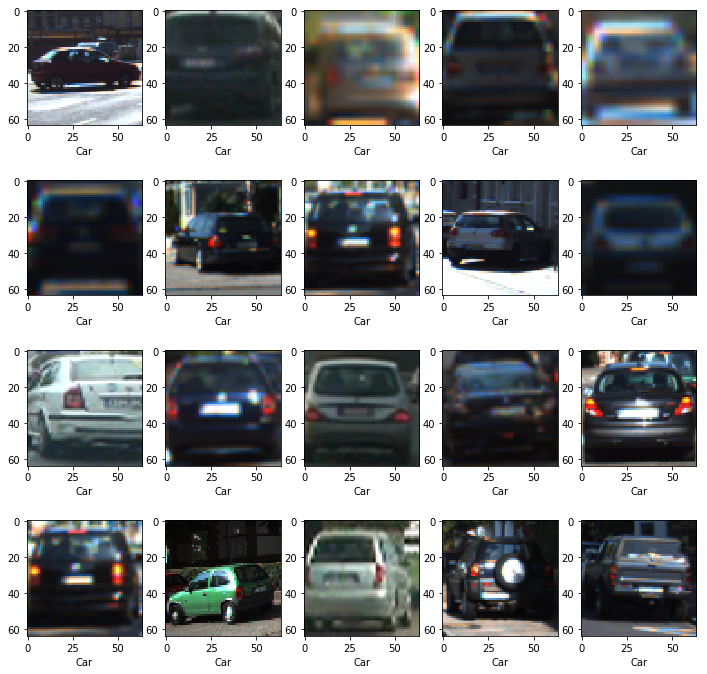

In [4]:
plt.figure(figsize=(12,12))

for x in range(Num_Show):
    rnd_int =random.randint(0,n_cartrain)
    rndImg = mpimg.imread(cars[rnd_int])
    plt.subplot(4,5,x+1)
    plt.imshow(rndImg)
    plt.xlabel('Car')
  
plt.show()

## HOG Extraction and Visulization 

Visualization of HOG features of Non-cars


C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


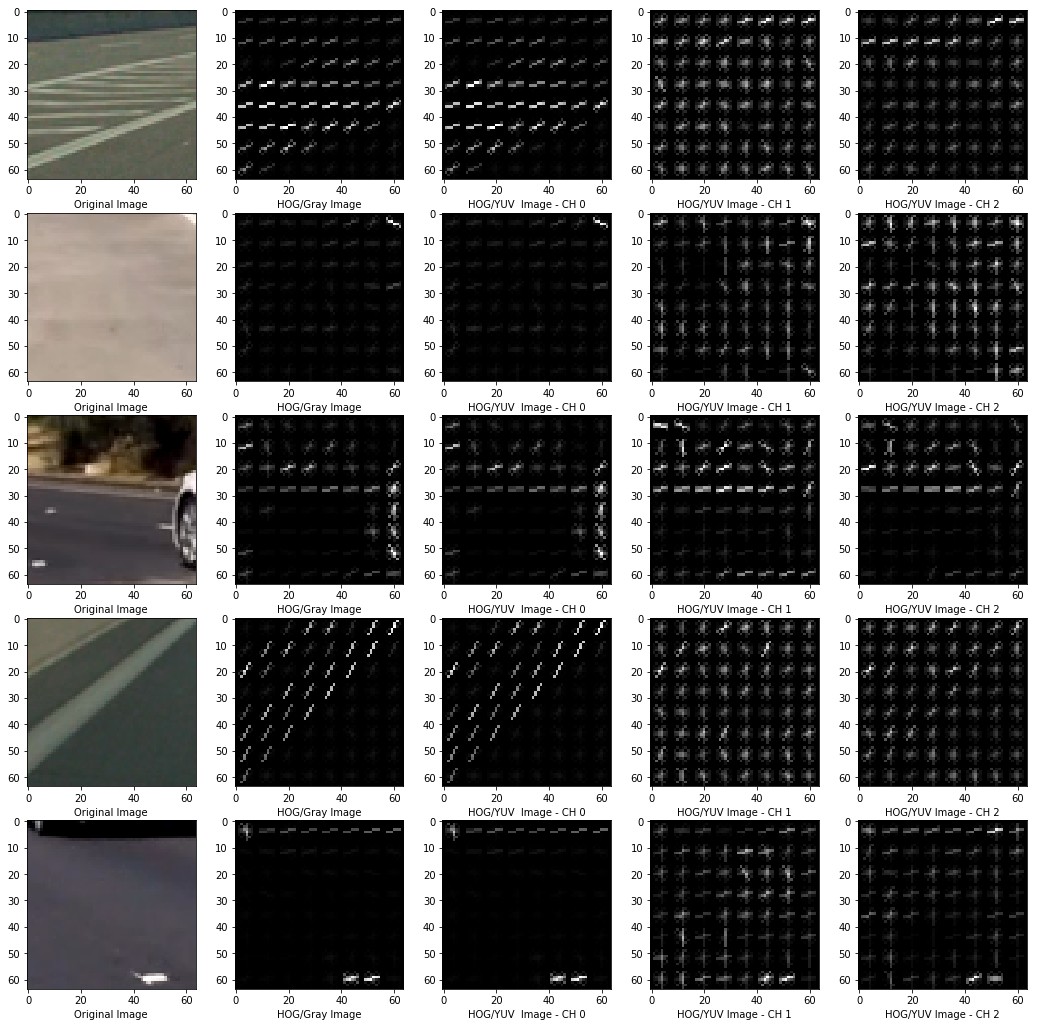

In [5]:
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2

Num_show2 = 5 
print("Visualization of HOG features of Non-cars")
plt.figure(figsize=(18,18))
for x in range(Num_show2):
    rnd_int = random.randint(0,n_ncartrain) 
    img = mpimg.imread(notcars[rnd_int])
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    features, hog_image1 = hog(feature_image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    features, hog_image2 = hog(feature_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    features, hog_image3 = hog(feature_image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    features, hog_image4 = hog(feature_image[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
    
    
    plt.subplot(5,5,(5*x)+1)
    plt.imshow(img)
    plt.xlabel("Original Image")
    plt.subplot(5,5,(5*x)+2)
    plt.imshow(hog_image1, cmap='gray')
    plt.xlabel("HOG/Gray Image")
    plt.subplot(5,5,(5*x)+3)
    plt.imshow(hog_image2,cmap='gray')
    plt.xlabel("HOG/YUV  Image - CH 0")
    plt.subplot(5,5,(5*x)+4)
    plt.imshow(hog_image3,cmap='gray')
    plt.xlabel("HOG/YUV Image - CH 1")
    plt.subplot(5,5,(5*x)+5)
    plt.imshow(hog_image4, cmap='gray')
    plt.xlabel("HOG/YUV Image - CH 2")

plt.show()

Visualization of HOG features of Cars


C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)
C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:144: RuntimeWarning: invalid value encountered in sqrt
  image = np.sqrt(image)
C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:190: RuntimeWarning: invalid value encountered in remainder
  orientations, orientation_histogram)


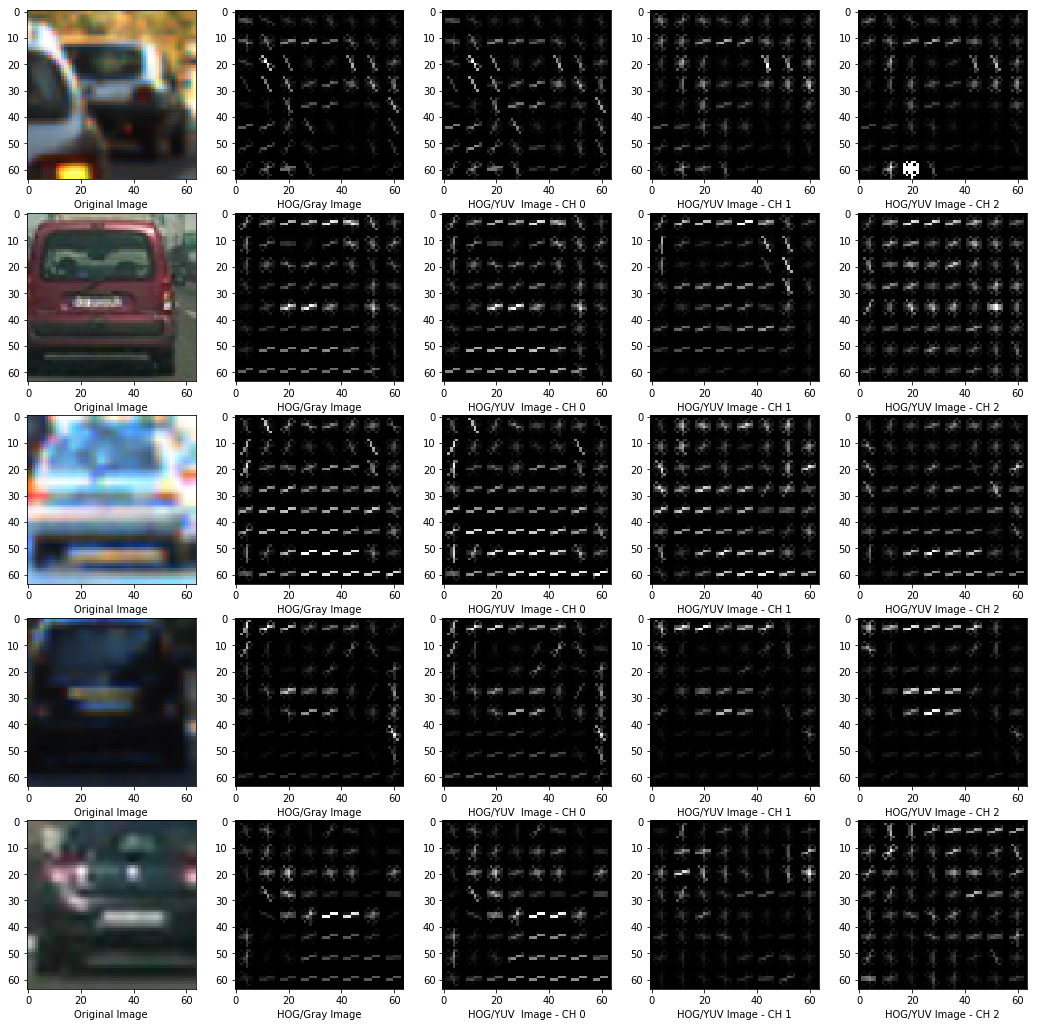

In [6]:
print("Visualization of HOG features of Cars")
plt.figure(figsize=(18,18))
for x in range(Num_show2):
    rnd_int = random.randint(0,n_cartrain) 
    img = mpimg.imread(cars[rnd_int])
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    features, hog_image1 = hog(feature_image, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
        
    feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    
    features, hog_image2 = hog(feature_image[:,:,0], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True,visualise=True, feature_vector=False)
    features, hog_image3 = hog(feature_image[:,:,1], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True, visualise=True, feature_vector=False)
    features, hog_image4 = hog(feature_image[:,:,2], orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=True, visualise=True, feature_vector=False)
    
    
    plt.subplot(5,5,(5*x)+1)
    plt.imshow(img)
    plt.xlabel("Original Image")
    plt.subplot(5,5,(5*x)+2)
    plt.imshow(hog_image1, cmap='gray')
    plt.xlabel("HOG/Gray Image")
    plt.subplot(5,5,(5*x)+3)
    plt.imshow(hog_image2,cmap='gray')
    plt.xlabel("HOG/YUV  Image - CH 0")
    plt.subplot(5,5,(5*x)+4)
    plt.imshow(hog_image3,cmap='gray')
    plt.xlabel("HOG/YUV Image - CH 1")
    plt.subplot(5,5,(5*x)+5)
    plt.imshow(hog_image4, cmap='gray')
    plt.xlabel("HOG/YUV Image - CH 2")

plt.show()

## Data Feature Extraction Functions

In [7]:
# Feature Extraction code is taken from the Udacity course curriculum

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [8]:
color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (12, 12) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = False # Spatial features on or off
hist_feat = False # Histogram features on or off
hog_feat = True # HOG features on or off

car_features = extract_features(cars, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
print(len(car_features))
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
print(len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
1
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=1)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))


C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


8792
8968
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
17.28 Seconds to train SVC...
Test Accuracy of SVC =  0.9797


In [9]:
"""
svc2 = tree.DecisionTreeClassifier()
# Check the training time for the SVC
t=time.time()
svc2.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train DecisionTree...')
# Check the score of the SVC
print('Test Accuracy of Decision Tree = ', round(svc2.score(X_test, y_test), 4))
"""

"\nsvc2 = tree.DecisionTreeClassifier()\n# Check the training time for the SVC\nt=time.time()\nsvc2.fit(X_train, y_train)\nt2 = time.time()\nprint(round(t2-t, 2), 'Seconds to train DecisionTree...')\n# Check the score of the SVC\nprint('Test Accuracy of Decision Tree = ', round(svc2.score(X_test, y_test), 4))\n"

In [10]:
svc3 = MLPClassifier(solver='lbfgs', alpha=1e-5, random_state=1)
# Check the training time for the SVC
t=time.time()
svc3.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train MLPClassifier...')
# Check the score of the SVC
print('Test Accuracy of MLP = ', round(svc3.score(X_test, y_test), 4))
print('Training Accuracy of MLP = ', round(svc3.score(X_train, y_train), 4))

5.34 Seconds to train MLPClassifier...
Test Accuracy of MLP =  0.9924
Training Accuracy of MLP =  1.0


## Define Window Search functions

In [11]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [12]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        #print(window)
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        #print(test_img.shape)
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        """
        prediction = clf.predict_proba(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction[0][1]>0.95:
            on_windows.append(window)
        """
        prediction = clf.predict(test_features)
        if (prediction == 1):
            on_windows.append(window)
        
       
    #8) Return windows for positive detections
    return on_windows

In [13]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


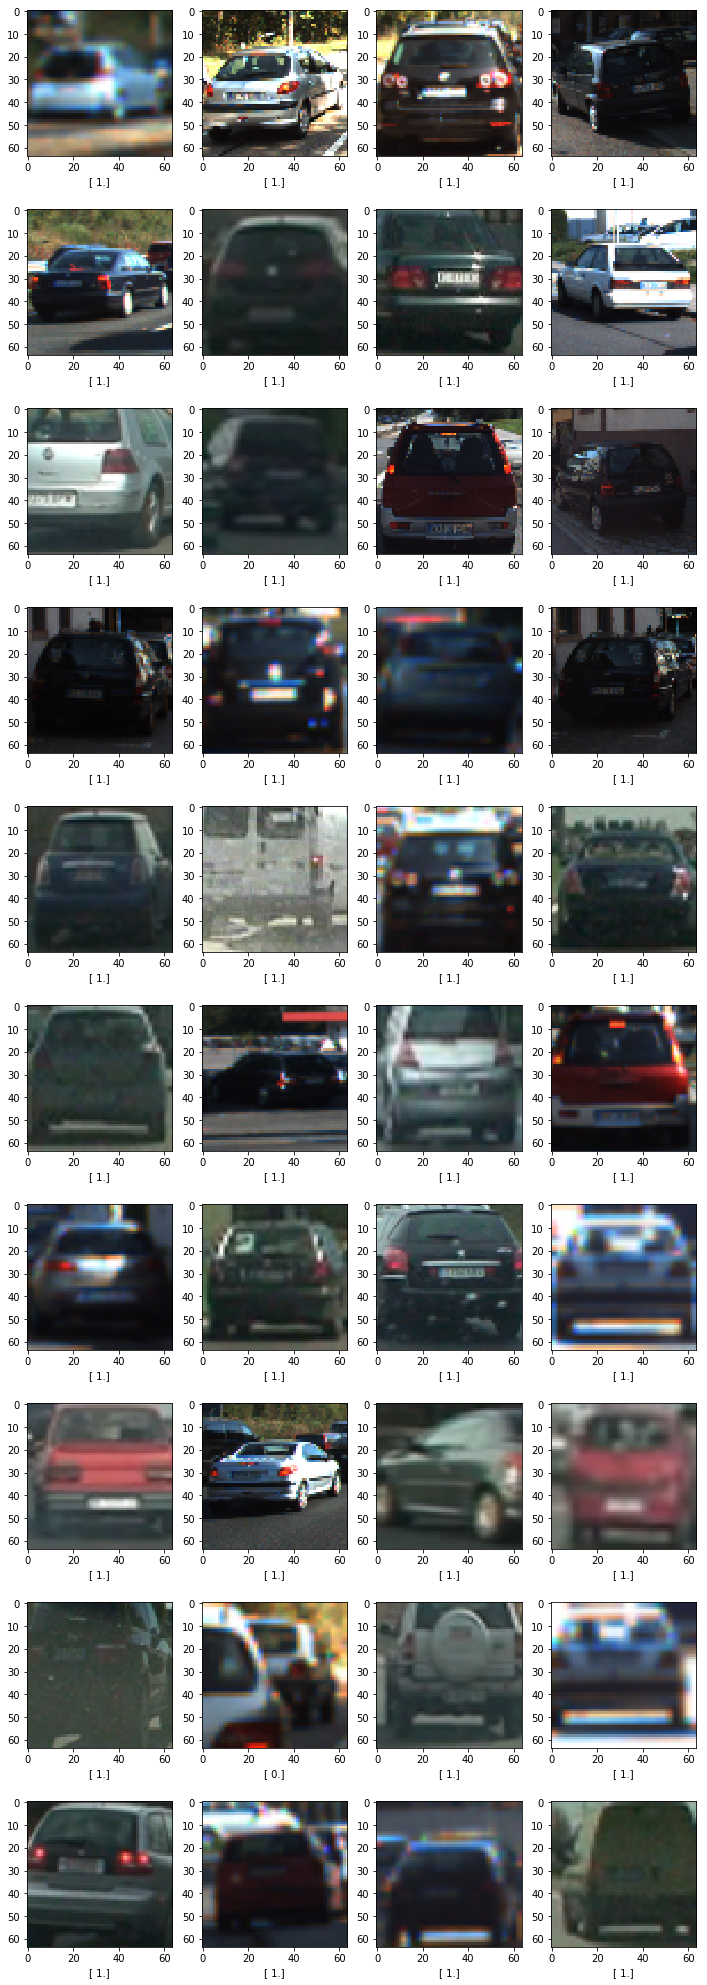

In [14]:
test_Num=40
plt.figure(figsize=(12,36))
for x in range(test_Num):
    rnd_int = random.randint(0,n_cartrain) 
    img = mpimg.imread(cars[rnd_int])
    
    xfeatures = single_img_features(img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
    test_features = X_scaler.transform(np.array(xfeatures).reshape(1, -1))
    prediction = svc.predict(test_features)
    plt.subplot(10,4,x+1)
    plt.imshow(img)
    plt.xlabel(prediction)

plt.show()


    

C:\Users\ExtEng\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


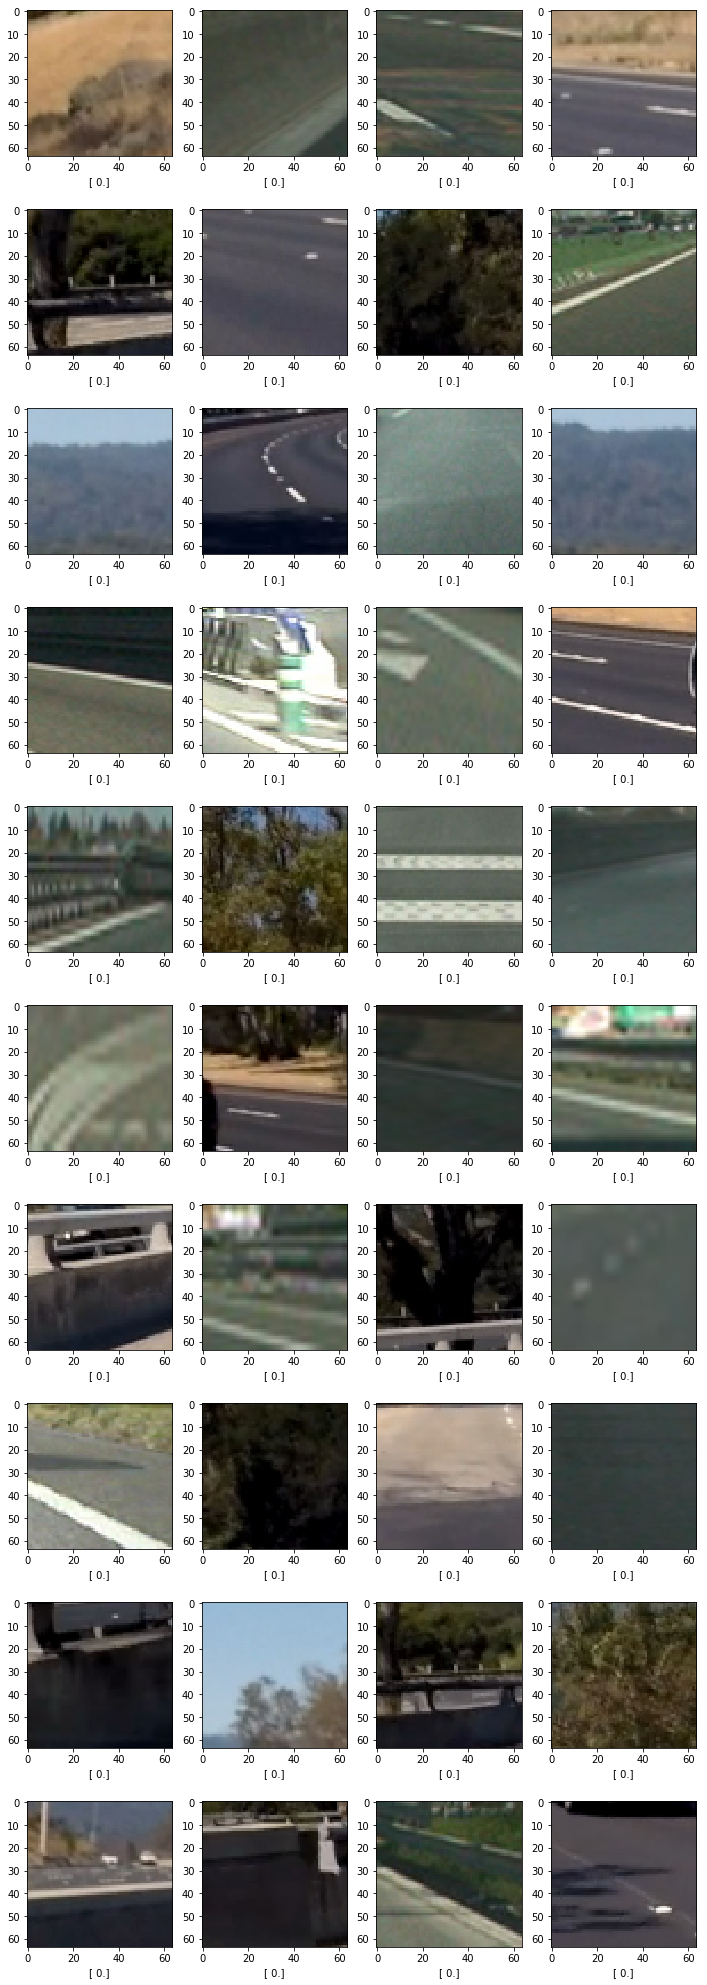

In [15]:
test_Num=40
plt.figure(figsize=(12,36))
for x in range(test_Num):
    rnd_int = random.randint(0,n_ncartrain) 
    img = mpimg.imread(notcars[rnd_int])
    
    xfeatures = single_img_features(img, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell,cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat,hist_feat=hist_feat, hog_feat=hog_feat)
    test_features = X_scaler.transform(np.array(xfeatures).reshape(1, -1))
    prediction = svc.predict(test_features)
    plt.subplot(10,4,x+1)
    plt.imshow(img)
    plt.xlabel(prediction)

plt.show()


(720, 1280, 3)


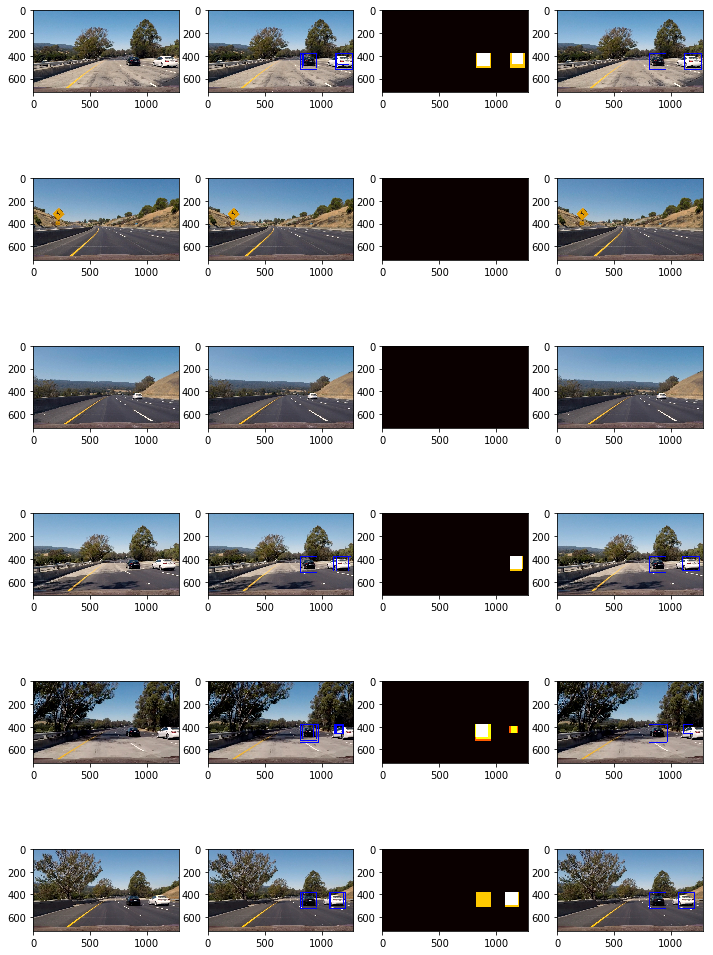

In [24]:
from scipy.ndimage.measurements import label
testImgs= glob.glob('test_images\*')

img=mpimg.imread(testImgs[0])

n=len(testImgs)
imshape = img.shape
print(imshape)
plt.figure(figsize=(12,18))
y_start_stop = [380, 650] 

for x in range(n):
    test_img = mpimg.imread(testImgs[x])
    plt.subplot(n,4,(4*x)+1)
    plt.imshow(test_img)
    win = 256 
    y_start_stop[1] = 650
    windows=[]
    draw_image = np.copy(test_img)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    while (win >= 64): # tested 48 : 8000 ~ scan windows ; 64: 765 
        windows_i = slide_window(test_img, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(win, win), xy_overlap=(0.8, 0.8))
        win -= 16
        y_start_stop[1] -= 16
        windows.extend(windows_i)
        #print(len(windows))
    
    hot_windows = search_windows(test_img, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL', spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
        #print(hot_windows)
        
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
    heatmap =add_heat(heat,hot_windows)
    labels = label(heatmap)   
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    
    plt.subplot(n,4,(4*x)+2)
    plt.imshow(window_img)
    plt.subplot(n,4,(4*x)+3)
    plt.imshow(heatmap, cmap='hot')
    plt.subplot(n,4,(4*x)+4)
    plt.imshow(draw_img)                              
plt.show()

In [25]:
print(len(windows))

765


## Define Pipeline

In [26]:
y_start_stop = [380, 650] 

def pipeline(image):
    win = 256 
    y_start_stop[1] = 650
    windows=[]
    draw_image = np.copy(image)
    
    
    while (win >= 64):
        windows_i = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(win, win), xy_overlap=(0.8, 0.8))
        win -= 16
        y_start_stop[1] -= 16
        windows.extend(windows_i)
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel='ALL', spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       
     
    #window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    heatmap =add_heat(heat,hot_windows)
    labels = label(heatmap)   
    
    heat = apply_threshold(heat,1)
    heatmap = np.clip(heat, 0, 255)
    
    draw_img = draw_labeled_bboxes(draw_image, labels)
    return draw_img                             



In [27]:
from moviepy.editor import VideoFileClip

clipOut = 'Output_test_video_scanwindow_64_16_y_resize.mp4'
clip1 = VideoFileClip("test_video.mp4")

clip = clip1.fl_image(pipeline)
%time clip.write_videofile(clipOut, audio=False)

[MoviePy] >>>> Building video Output_test_video_scanwindow_64_16_y_resize.mp4
[MoviePy] Writing video Output_test_video_scanwindow_64_16_y_resize.mp4



 97%|████████████████████████████████████████████████████████████████████████████▉  | 38/39 [02:18<00:03,  3.63s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_test_video_scanwindow_64_16_y_resize.mp4 

Wall time: 2min 19s


In [28]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clipOut))

In [29]:
clipOut2 = 'Output_project_video_scanwindow_64_16_y_resize.mp4'
clip2 = VideoFileClip("project_video.mp4")

clip = clip2.fl_image(pipeline)
%time clip.write_videofile(clipOut2, audio=False)

[MoviePy] >>>> Building video Output_project_video_scanwindow_64_16_y_resize.mp4
[MoviePy] Writing video Output_project_video_scanwindow_64_16_y_resize.mp4



  5%|████                                                                       | 69/1261 [04:12<1:11:35,  3.60s/it]


 11%|████████▏                                                                 | 139/1261 [08:25<1:07:21,  3.60s/it]


 17%|████████████▎                                                             | 209/1261 [12:36<1:03:04,  3.60s/it]


 22%|████████████████▊                                                           | 279/1261 [16:48<59:22,  3.63s/it]


 28%|█████████████████████                                                       | 349/1261 [21:00<53:57,  3.55s/it]


 33%|█████████████████████████▎                                                  | 419/1261 [25:13<50:22,  3.59s/it]


 39%|█████████████████████████████▍                                              | 489/1261 [29:25<46:09,  3.59s/it]


 44%|█████████████████████████████████▋                                          | 559/1261 [33:35<43:01,  3.68s/it]


 50%|█████████████████████████████████████▉                                      | 629/1261 [37:45<37:44,  3.58s/it]


 55%|██████████████████████████████████████████▏                                 | 699/1261 [41:55<33:14,  3.55s/it]


 61%|██████████████████████████████████████████████▎                             | 769/1261 [46:07<29:36,  3.61s/it]


 67%|██████████████████████████████████████████████████▌                         | 839/1261 [50:20<25:30,  3.63s/it]


 72%|██████████████████████████████████████████████████████▊                     | 909/1261 [54:31<21:09,  3.61s/it]


 78%|███████████████████████████████████████████████████████████                 | 979/1261 [58:45<17:18,  3.68s/it]


 83%|████████████████████████████████████████████████████████████▋            | 1049/1261 [1:02:59<13:01,  3.68s/it]


 89%|████████████████████████████████████████████████████████████████▊        | 1119/1261 [1:07:18<09:27,  4.00s/it]


 94%|████████████████████████████████████████████████████████████████████▊    | 1189/1261 [1:11:45<04:21,  3.63s/it]


100%|████████████████████████████████████████████████████████████████████████▉| 1259/1261 [1:16:04<00:07,  3.66s/it]


100%|████████████████████████████████████████████████████████████████████████▉| 1260/1261 [1:16:07<00:03,  3.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Output_project_video_scanwindow_64_16_y_resize.mp4 

Wall time: 1h 16min 8s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(clipOut2))